In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
from tqdm import tqdm
from detoxify import Detoxify

## Prova con Toxic-bert

In [ ]:
# Carica il modello
model_name = "unitary/toxic-bert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [ ]:
# Carica i messaggi
df = pd.read_csv("../../data/processed/cleaned_twitch_messages.csv")

In [ ]:
# Funzione per stimare la tossicità
def get_toxicity_score(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    # Usa il punteggio massimo tra le 6 classi
    score = torch.sigmoid(outputs.logits)[0].max().item()
    return score

In [ ]:
# Applica ai messaggi
tqdm.pandas()
df["toxicity_score"] = df["message"].progress_apply(get_toxicity_score)

In [ ]:
# Etichette: 1 = tossico, 0 = non tossico, -1 = ambiguo
#df["label"] = df["toxicity_score"].apply(lambda x: 1 if x >= 0.7 else (0 if x <= 0.3 else -1))
df["label"] = df["toxicity_score"].apply(lambda x: 1 if x >= 0.9 else 0 )


In [ ]:
df = pd.read_csv("messages_with_toxicity_labels.csv")

In [ ]:
# Salva
os.makedirs("data", exist_ok=True)
df.to_csv("./data/messages_with_toxicity_labels.csv", index=False)
print("✅ Etichettatura completata.")


In [ ]:
# 6️⃣ Visualizzazione del punteggio
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="toxicity_score", bins=30, kde=True, color="skyblue")
plt.title("Distribuzione dei punteggi di tossicità")
plt.xlabel("Toxicity score")
plt.ylabel("Numero di messaggi")
plt.show()

### Prova con CitizenLab distilbert-base-multilingual-cased-toxicity

In [ ]:
# Modello multilingua specializzato in tossicità
MODEL_NAME = "citizenlab/distilbert-base-multilingual-cased-toxicity"

In [ ]:
toxicity_classifier = pipeline("text-classification", model=MODEL_NAME, tokenizer=MODEL_NAME)

In [ ]:
# Funzione per etichettare e ottenere score
def classify_toxicity(text):
    result = toxicity_classifier(text[:512])[0]  # truncation manuale max input
    label = 1 if result["label"] == "toxic" else 0
    score = result["score"]
    return pd.Series([label, score])

In [ ]:
# Applica con progress bar
tqdm.pandas()
df[["label", "toxicity_score"]] = df["message"].progress_apply(classify_toxicity)

In [ ]:
# Etichette: soglie personalizzabili
df["label"] = df["toxicity_score"].apply(lambda x: 1 if x >= 0.6 else 0)

In [ ]:
df.to_csv("messages_labeled_citizenlab.csv", index=False)
print("✅ Etichettatura completata con il modello CitizenLab.")

In [ ]:
df = pd.read_csv("./messages_labeled_citizenlab.csv")

In [ ]:
sns.histplot(df["toxicity_score"], bins=70, kde=True, color="salmon")
plt.title("Distribuzione dei punteggi di tossicità (CitizenLab)")
plt.xlabel("Toxicity score")
plt.ylabel("Numero di messaggi")
plt.show()

In [ ]:
df.query("toxicity_score > 0.99")

## Prova con Detoxify

In [2]:
model = Detoxify('multilingual')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

c:\Users\antho\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\antho\.cache\huggingface\hub\models--xlm-roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [8]:
df = pd.read_csv("../../data/processed/cleaned_twitch_messages.csv")

In [9]:
def get_max_toxicity(text):
    try:
        scores = model.predict(text)
        return max(scores.values())  # score massimo tra tutte le classi tossiche
    except:
        return 0.0

In [10]:
tqdm.pandas()
df["toxicity_score"] = df["message"].progress_apply(get_max_toxicity)


100%|██████████| 99833/99833 [32:16<00:00, 51.56it/s]


In [11]:
df["label"] = df["toxicity_score"].apply(lambda x: 1 if x >= 0.7 else 0)

In [12]:
# Salva i risultati
df.to_csv("messages_labeled_detoxify.csv", index=False)
print("✅ Etichettatura completata con Detoxify")

✅ Etichettatura completata con Detoxify


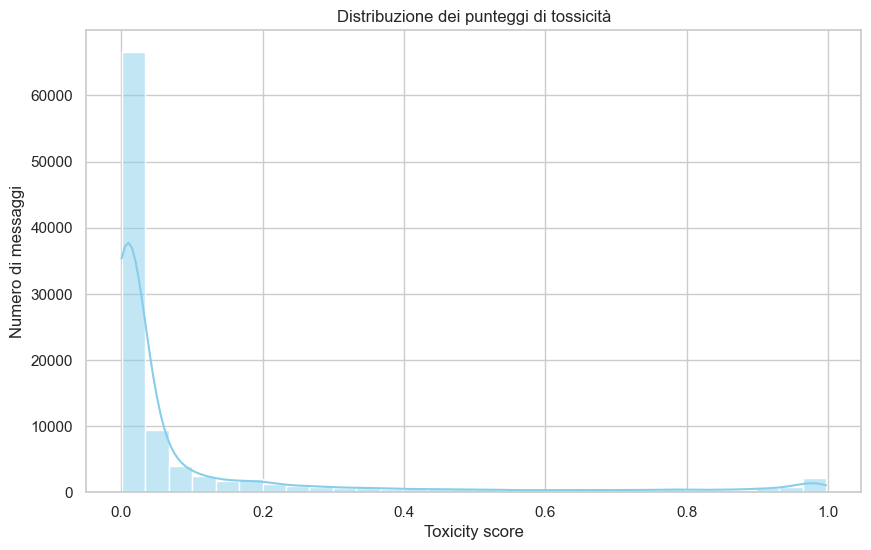

In [13]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="toxicity_score", bins=30, kde=True, color="skyblue")
plt.title("Distribuzione dei punteggi di tossicità")
plt.xlabel("Toxicity score")
plt.ylabel("Numero di messaggi")
plt.show()